In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime
from scipy.optimize import curve_fit
import bcchapi
from datetime import datetime, timedelta

# SPC y FWD Nominal

In [ ]:
from datetime import datetime
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import bcchapi

# ===================================================================
# DESCARGA DATOS BCCh
# ===================================================================
siete = bcchapi.Siete("luca.appiani@security.cl", "Security.2024")
hoy = datetime.today().strftime("%Y-%m-%d")

# Tasas SPC
df_spc = siete.cuadro(
    series=["F022.SPC.TPR.D090.NO.Z.D", "F022.SPC.TPR.D180.NO.Z.D", "F022.SPC.TPR.D360.NO.Z.D",
            "F022.SPC.TIN.AN02.NO.Z.D", "F022.SPC.TIN.AN03.NO.Z.D", "F022.SPC.TIN.AN04.NO.Z.D",
            "F022.SPC.TIN.AN05.NO.Z.D", "F022.SPC.TIN.AN10.NO.Z.D"],
    nombres=["90d", "180d", "1y", "2y", "3y", "4y", "5y", "10y"],
    desde="2024-01-01", hasta=hoy, frecuencia="D", observado="last"
)

fecha = df_spc.index[-1]
tasas_spc = df_spc.loc[fecha].values / 100

# TPM actual
df_tpm = siete.cuadro(series=["F022.TPM.TIN.D001.NO.Z.D"], nombres=["TPM"], desde=hoy, hasta=hoy)
TPM_pct = df_tpm["TPM"].iloc[-1]
TPM = TPM_pct / 100

# ===================================================================
# ANCLA + AJUSTE SVENSSON
# ===================================================================
plazos = np.array([0.25, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0])
maturities = np.concatenate([[0.002778], plazos])
rates = np.concatenate([[TPM], tasas_spc])
weights = np.ones(len(maturities)); weights[0] = 1_000_000

def svensson_yield(t, b0, b2, b3, t1, t2):
    b1 = b0 - TPM
    t = np.maximum(np.atleast_1d(t), 1e-8)
    result = (b0 + b1*(1-np.exp(-t/t1))/(t/t1) + 
              b2*((1-np.exp(-t/t1))/(t/t1) - np.exp(-t/t1)) + 
              b3*((1-np.exp(-t/t2))/(t/t2) - np.exp(-t/t2)))
    return result.item() if result.size == 1 else result

def svensson_forward(t, b0, b2, b3, t1, t2):
    b1 = b0 - TPM
    t = np.atleast_1d(t)
    result = b0 + b1*np.exp(-t/t1) + b2*(t/t1)*np.exp(-t/t1) + b3*(t/t2)*np.exp(-t/t2)
    return result.item() if result.size == 1 else result

def residuals(p):
    return (svensson_yield(maturities, *p) - rates) * np.sqrt(weights)

initial = [TPM + 0.005, 0.01, -0.01, 0.6, 5.0]
bounds = ([TPM-0.03, -0.5, -0.5, 0.1, 1.0], [TPM+0.15, 0.5, 0.5, 4.0, 25.0])
params = opt.least_squares(residuals, initial, bounds=bounds, ftol=1e-13, max_nfev=20000).x

# ===================================================================
# CURVAS
# ===================================================================
years = np.linspace(0.01, 15.0, 800)
spot = svensson_yield(years, *params) * 100
fwd  = svensson_forward(years, *params) * 100

# ===================================================================
# GRÁFICO MINIMALISTA Y PROFESIONAL (sin grid, sin anotaciones)
# ===================================================================
plt.figure(figsize=(9, 5.2))

plt.plot(years, spot, color='#1f77b4', lw=2.8, label='Spot')
plt.plot(years, fwd,  color='#ff7f0e', lw=2.5, linestyle='--', label='Forward')

# Puntos observados
plt.scatter(plazos, tasas_spc*100, color='red', s=60, zorder=5, edgecolor='black', linewidth=0.7)
plt.scatter(0.002778, TPM*100, color='green', s=180, marker='D', edgecolor='black', linewidth=1.5,
            label=f'TPM {TPM_pct:.2f}%', zorder=10)

# Título limpio (toda la info en una sola línea)
plt.title(f"Curva Svensson • TPM {TPM_pct:.2f}% • {fecha.strftime('%d-%b-%Y')}",
          fontsize=14, pad=20, color='#2c3e50')

plt.xlabel("Plazo (años)", fontsize=11)
plt.ylabel("Tasa (%)", fontsize=11)
plt.legend(fontsize=10, loc='upper right')

plt.xlim(0, 15)
plt.ylim(min(fwd)*0.98, max(spot)*1.02)

# Sin grid, sin bordes superiores/derechos
ax = plt.gca()
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# ===================================================================
# RESUMEN EN CONSOLA (solo lo esencial)
# ===================================================================
min_year = years[fwd.argmin()]
print(f"\nCurva actualizada: {fecha.date()} | TPM: {TPM_pct:.2f}%")
print(f"Forward mínimo: {fwd.min():.3f}% @ {min_year:.2f} años")
print(f"Spot 5 años : {svensson_yield(5, *params)*100:.3f}%")
print(f"Spot 10 años: {svensson_yield(10, *params)*100:.3f}%")

In [ ]:
from datetime import datetime

# ===================================================================
# PROBABILIDADES DE RECORTE EN PRÓXIMAS RPM (2025-2026)
# ===================================================================
fechas_rpm = [
    datetime(2026, 1, 27),   # Ene 2026
    datetime(2026, 3, 21),   # Mar 2026
    datetime(2026, 4, 28),   # Abr 2026
    datetime(2026, 6, 17),   # Jun 2026
    datetime(2026, 9, 9),    # Sep 2026
    datetime(2026, 12, 16)   # Dic 2026
]

TPM_actual = TPM_pct  # ← ya lo tienes calculado arriba (ej: 4.75)

print("\n" + "═"*100)
print(f" EXPECTATIVAS DE MERCADO PARA PRÓXIMAS RPM")
print(f" Curva: {fecha.strftime('%d-%b-%Y')} | TPM actual: {TPM_actual:.2f}%")
print("═"*100)
print(f"{'Reunión':<12} {'Días':>6} {'Forward':>10} {'vs TPM':>10} {'Prob -25pb':>14} {'Prob -50pb':>14}")
print("─"*100)

for fecha_rpm in fechas_rpm:
    dias = (fecha_rpm - fecha).days
    
    if dias <= 0:
        print(f"{fecha_rpm.strftime('%d-%b-%y'):<12} {'pasada':>6} {'':>10} {'':>10} {'':>14} {'':>14}")
        continue

    años = dias / 365.0

    # Ya tienes la función svensson_forward con .item() → devuelve float directamente
    fwd_rate_pct = svensson_forward(años, *params) * 100

    diff_pb = TPM_actual - fwd_rate_pct
    prob_25pb = max(0.0, min(100.0, diff_pb * 400))      # equivalente a /0.25 * 100
    prob_50pb = max(0.0, min(100.0, diff_pb * 200))      # equivalente a /0.50 * 100

    print(f"{fecha_rpm.strftime('%d-%b-%y'):<12} {dias:>6} {fwd_rate_pct:>9.3f}% {diff_pb:+8.1f}pb "
          f"{prob_25pb:>11.1f}% {prob_50pb:>11.1f}%")

print("═"*100)


════════════════════════════════════════════════════════════════════════════════════════════════════
 EXPECTATIVAS DE MERCADO PARA PRÓXIMAS RPM
 Curva: 15-dic.-2025 | TPM actual: 4.75%
════════════════════════════════════════════════════════════════════════════════════════════════════
Reunión        Días    Forward     vs TPM     Prob -25pb     Prob -50pb
────────────────────────────────────────────────────────────────────────────────────────────────────
16-dic.-25        1     4.747%     +0.0pb         1.2%         0.6%
27-ene.-26       43     4.539%     +0.2pb        84.3%        42.1%
21-mar.-26       96     4.384%     +0.4pb       100.0%        73.1%
28-abr.-26      134     4.327%     +0.4pb       100.0%        84.6%
17-jun.-26      184     4.300%     +0.5pb       100.0%        90.0%
09-sep.-26      268     4.333%     +0.4pb       100.0%        83.5%
16-dic.-26      366     4.433%     +0.3pb       100.0%        63.3%
════════════════════════════════════════════════════════════════

# Depósitos en bolsa

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

In [ ]:
# --- Fechas ---
fecha_hoy = datetime.today()
fecha_inicio = (fecha_hoy - relativedelta(years=1)).strftime("%Y-%m-%d")
fecha_hoy = fecha_hoy.strftime("%Y-%m-%d")

# --- Descargar tasas DAP ---
df_dap = siete.cuadro(
    series=["F022.TDB.TIS.D030.NO.Z.D","F022.TDB.TIS.D090.NO.Z.D",
            "F022.TDB.TIS.D180.NO.Z.D", "F022.TDB.TIS.AN01.NO.Z.D"],
    nombres=["DAP 30 días", "DAP 90 días", "DAP 180 días", "DAP 360 días"],
    desde=fecha_inicio,
    hasta=fecha_hoy,
    frecuencia="D",
    observado={
        "DAP 30 días": "last",
        "DAP 90 días": "last",
        "DAP 180 días": "last",
        "DAP 360 días": "last"
    }
)

# Eliminar valores nulos
df_dap = df_dap.dropna(how="all")

# --- Convertir tasas a base mensual ---
for col in df_dap.columns:
    df_dap[col] = df_dap[col] / 12


C:\Users\lappiani\AppData\Local\Temp\ipykernel_32056\3101747548.py:32: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  fecha_mes_atras = df_dap.index[df_dap.index.get_loc(fecha_mes_atras, method="nearest")]


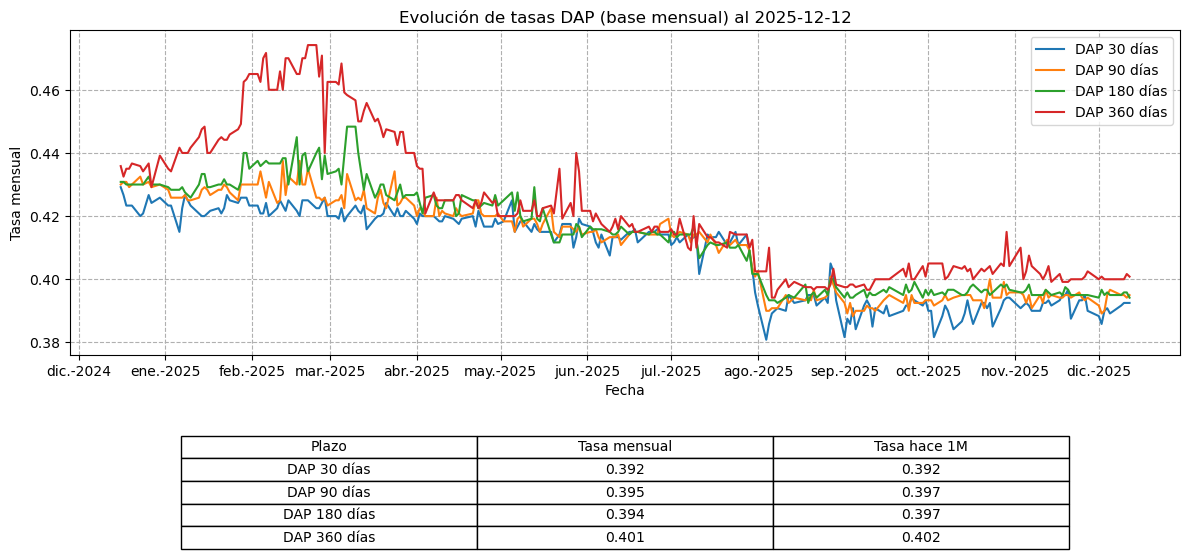

In [ ]:
from datetime import timedelta
import matplotlib.dates as mdates
import locale

# Establecer idioma español para los meses (puede requerir tener el locale instalado en tu SO)
locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8')

# --- Graficar historia de tasas DAP ---
plt.figure(figsize=(12, 8))

for col in df_dap.columns:
    plt.plot(df_dap.index, df_dap[col], label=col)

# --- Fecha actual ---
fecha_actual = df_dap.index[-1]

plt.title(f"Evolución de tasas DAP (base mensual) al {fecha_actual.date()}")
plt.xlabel("Fecha")
plt.ylabel("Tasa mensual")
plt.legend()
plt.grid(linestyle="--")

# --- Configurar eje X para mostrar solo los meses ---
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())            # Cada mes
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))  # Formato: Ene-2025

plt.tight_layout()

# --- Crear tabla con los últimos valores y tasas de hace 1 mes ---
fecha_mes_atras = fecha_actual - timedelta(days=30)
fecha_mes_atras = df_dap.index[df_dap.index.get_loc(fecha_mes_atras, method="nearest")]

tasas_actuales = df_dap.loc[fecha_actual]
tasas_anteriores = df_dap.loc[fecha_mes_atras]

ultimos_valores = tasas_actuales.round(3)
valores_hace_1m = tasas_anteriores.round(3)

# Crear DataFrame de tabla (reemplazo de variación % por "Tasa hace 1M")
tabla_datos = pd.DataFrame({
    "Plazo": ultimos_valores.index,
    "Tasa mensual": ultimos_valores.values,
    "Tasa hace 1M": valores_hace_1m.values
})

# --- Agregar tabla debajo del gráfico con espaciado adicional ---
tabla = plt.table(cellText=tabla_datos.values,
                  colLabels=tabla_datos.columns,
                  cellLoc="center",
                  loc="bottom",
                  bbox=[0.1, -0.6, 0.8, 0.35])  # Más abajo y más grande

tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1.2, 1.5)

# Ajustar espacio inferior para la tabla
plt.subplots_adjust(bottom=0.55)
plt.show()


## Inflación

        Fecha  IPC_12m  IPC_SV_12m
54 2025-07-31      4.3    3.980122
55 2025-08-31      4.0    3.884370
56 2025-09-30      4.4    3.943217
57 2025-10-31      3.4    3.441441
58 2025-11-30      3.4    3.402964


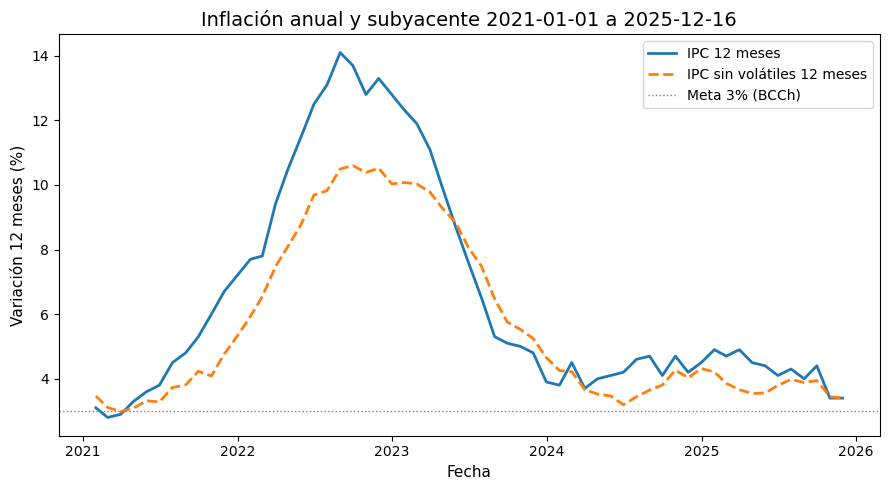

In [ ]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import bcchapi   # pip install bcchapi

# =====================================================
# PARÁMETROS GENERALES
# =====================================================

USUARIO = "luca.appiani@security.cl"
CLAVE   = "Security.2024"

# OJO: reemplaza estos códigos por los que correspondan en tu Siete
# Ejemplos de NOMBRES que podrías buscar en Siete:
# - "IPC, variación anual"
# - "IPC sin volátiles, variación anual"
SERIE_IPC_ANUAL     = "F074.IPC.V12.Z.EP23.C.M"       # <-- reemplazar
SERIE_IPC_SV_ANUAL  = "G073.IPCSV.V12.2023.M"     # <-- reemplazar

# =====================================================
# FUNCIÓN: DESCARGAR DATA
# =====================================================

def descargar_inflacion_anual(fecha_desde: str, fecha_hasta: str) -> pd.DataFrame:
    """
    Descarga inflación anual total e inflación subyacente (sin volátiles)
    desde el BCCh usando bcchapi y devuelve un DataFrame mensual.

    Parámetros:
        fecha_desde: 'YYYY-MM-DD'
        fecha_hasta: 'YYYY-MM-DD'

    Retorna:
        DataFrame con columnas:
        ['Fecha', 'IPC_12m', 'IPC_SV_12m']
    """
    siete = bcchapi.Siete(USUARIO, CLAVE)

    df = siete.cuadro(
        series=[SERIE_IPC_ANUAL, SERIE_IPC_SV_ANUAL],
        nombres=["IPC_12m", "IPC_SV_12m"],
        desde=fecha_desde,
        hasta=fecha_hasta,
        frecuencia="M",      # mensual
        observado="last"     # último dato del mes
    )

    # Pasar índice (fecha) a columna
    df = df.reset_index().rename(columns={"index": "Fecha"})

    # Asegurar tipo datetime
    df["Fecha"] = pd.to_datetime(df["Fecha"])

    return df

# =====================================================
# FUNCIÓN: GRÁFICO
# =====================================================

def graficar_inflacion_anual(df: pd.DataFrame, titulo_extra: str = ""):
    """
    Grafica inflación anual total y subyacente en el tiempo.
    """
    plt.figure(figsize=(9, 5))

    plt.plot(df["Fecha"], df["IPC_12m"], label="IPC 12 meses", linewidth=2)
    plt.plot(df["Fecha"], df["IPC_SV_12m"], label="IPC sin volátiles 12 meses",
             linestyle="--", linewidth=2)

    plt.axhline(3, color="gray", linestyle=":", linewidth=1, label="Meta 3% (BCCh)")

    plt.title(f"Inflación anual y subyacente {titulo_extra}".strip(), fontsize=14)
    plt.xlabel("Fecha", fontsize=11)
    plt.ylabel("Variación 12 meses (%)", fontsize=11)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

# =====================================================
# EJEMPLO DE USO
# =====================================================

if __name__ == "__main__":
    # Rango de fechas (ajusta a gusto)
    fecha_desde = "2021-01-01"
    fecha_hasta = datetime.today().strftime("%Y-%m-%d")

    # 1) Descargar datos
    df_inflacion = descargar_inflacion_anual(fecha_desde, fecha_hasta)

    # 2) Ver las últimas filas (control rápido)
    print(df_inflacion.tail())

    # 3) Graficar
    graficar_inflacion_anual(df_inflacion, titulo_extra=f"{fecha_desde} a {fecha_hasta}")

    # 4) Si quieres dejarlo listo para Excel:
    # df_inflacion.to_excel("inflacion_anual_y_subyacente.xlsx", index=False)


# Bonos de Tesoreria

## Pesos

In [ ]:
# --- Descargar tasas DAP ---
df_bonos = siete.cuadro(
    series=["F022.BCLP.TIS.AN01.NO.Z.D", "F022.BCLP.TIS.AN02.NO.Z.D",
            "F022.BCLP.TIS.AN05.NO.Z.D", "F022.BCLP.TIS.AN10.NO.Z.D"],
    nombres=["BTP 1 año", "BTP 2 años", "BTP 5 años", "BTP 10 años"],
    desde=fecha_inicio,
    hasta=fecha_hoy,
    frecuencia="D",
    observado={
        "BTP 1 año": "last",
        "BTP 2 años": "last",
        "BTP 5 años": "last",
        "BTP 10 años": "last"
    }
)


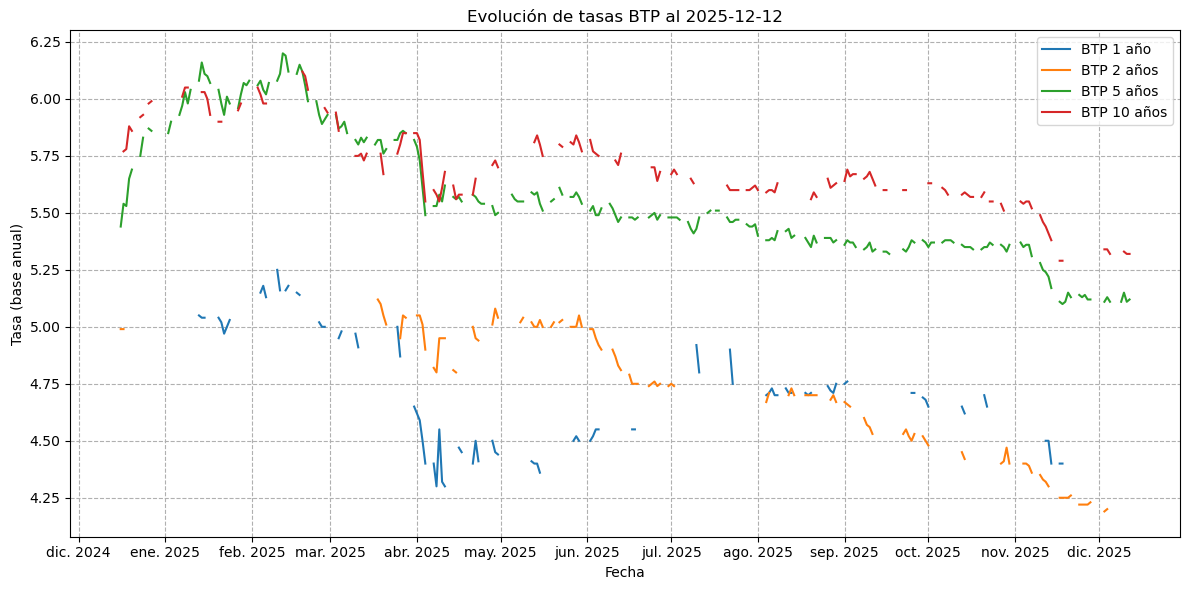

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Graficar historia de tasas BTP ---
plt.figure(figsize=(12, 6))

for col in df_bonos.columns:
    plt.plot(df_bonos.index, df_bonos[col], label=col)

# --- Fecha actual ---
fecha_actual = df_bonos.index[-1]

plt.title(f"Evolución de tasas BTP al {fecha_actual.date()}")
plt.xlabel("Fecha")
plt.ylabel("Tasa (base anual)")
plt.legend()
plt.grid(linestyle="--")

# Formato de fechas: mostrar meses en español
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.tight_layout()
plt.show()


In [ ]:
# from scipy.optimize import curve_fit
# import numpy as np
# import matplotlib.pyplot as plt

# tpm_valor = df_tpm.iloc[-1, 0]  # TPM en base anual

# # --- Seleccionar última fecha ---
# fecha_objetivo = df_bonos.index[-1]
# tasas_fecha_btp = df_bonos.loc[fecha_objetivo]

# # --- Crear DataFrame incluyendo TPM como 1 día para BTP ---
# df_tasas_btp = pd.DataFrame({
#     "Plazo": [1/365, 1, 2, 5, 10],
#     "BTP": [tpm_valor] + tasas_fecha_btp.values.tolist()
# })

# # --- Estimar Svensson para BTP ---
# maturities_btp = df_tasas_btp["Plazo"].values
# rates_btp = df_tasas_btp["BTP"].values
# params_svensson_btp = estimate_svensson_params(maturities_btp, rates_btp)

# # --- Crear DataFrame incluyendo TPM como 1 día para Swap ---
# tasas_fecha_spc = df_spc.loc[fecha_objetivo]
# df_tasas_spc = pd.DataFrame({
#     "Plazo": [1/365, 0.25, 0.5, 1, 2, 3, 4, 5, 10],
#     "SPC": [tpm_valor] + tasas_fecha_spc.values.tolist()
# })

# # --- Estimar Svensson para Swap ---
# maturities_spc = df_tasas_spc["Plazo"].values
# rates_spc = df_tasas_spc["SPC"].values
# params_svensson_spc = estimate_svensson_params(maturities_spc, rates_spc)

# # --- Generar curvas ---
# rango_anos = np.linspace(1/365, 10, 50)  # Menos puntos para barras de spread
# yields_svensson_btp = svensson_yield(rango_anos, *params_svensson_btp)
# yields_svensson_spc = svensson_yield(rango_anos, *params_svensson_spc)

# # --- Calcular spread en puntos base ---
# spread_barras = (yields_svensson_spc - yields_svensson_btp) * 100  # En bps

# # --- Crear figura con subplots ---
# fig, axs = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [2, 1]})

# # --- Subplot 1: Curvas Svensson ---
# axs[0].plot(rango_anos, yields_svensson_btp, color="red", label="Curva Svensson BTP")
# axs[0].plot(rango_anos, yields_svensson_spc, color="blue", linestyle="--", label="Curva Svensson Swap (SPC)")
# axs[0].set_xlabel("Plazo (años)")
# axs[0].set_ylabel("Tasa (base anual)")
# axs[0].set_title(f"Curvas Svensson BTP y Swap al {fecha_objetivo.date()}")
# axs[0].grid(linestyle="--")
# axs[0].legend()

# # --- Subplot 2: Spread como barras ---
# axs[1].bar(rango_anos, spread_barras, width=0.15, color="green")
# axs[1].axhline(0, color="black", linestyle="--", linewidth=1)
# axs[1].set_xlabel("Plazo (años)")
# axs[1].set_ylabel("Spread (bps)")
# axs[1].set_title("Swap Spread")
# axs[1].grid(linestyle="--", axis="y")

# plt.tight_layout()
# plt.show()


## UF

In [ ]:
# --- Descargar tasas Bonos en UF ---
df_bonos_uf = siete.cuadro(
    series=[
        "F022.BUF.TIS.AN01.UF.Z.D",  # Bonos UF 1 año
        "F022.BUF.TIS.AN02.UF.Z.D",  # Bonos UF 2 años
        "F022.BUF.TIS.AN05.UF.Z.D",  # Bonos UF 5 años
        "F022.BUF.TIS.AN10.UF.Z.D",  # Bonos UF 10 años
        "F022.BUF.TIS.AN20.UF.Z.D",  # Bonos UF 20 años
        "F022.BUF.TIS.AN30.UF.Z.D"   # Bonos UF 30 años
    ],
    nombres=[
        "BCU/BTU 1 año",
        "BCU/BTU 2 años",
        "BCU/BTU 5 años",
        "BCU/BTU 10 años",
        "BCU/BTU 20 años",
        "BCU/BTU 30 años"
    ],
    desde=fecha_inicio,
    hasta=fecha_hoy,
    frecuencia="D",
    observado={
        "BCU/BTU 1 año": "last",
        "BCU/BTU 2 años": "last",
        "BCU/BTU 5 años": "last",
        "BCU/BTU 10 años": "last",
        "BCU/BTU 20 años": "last",
        "BCU/BTU 30 años": "last"
    }
)


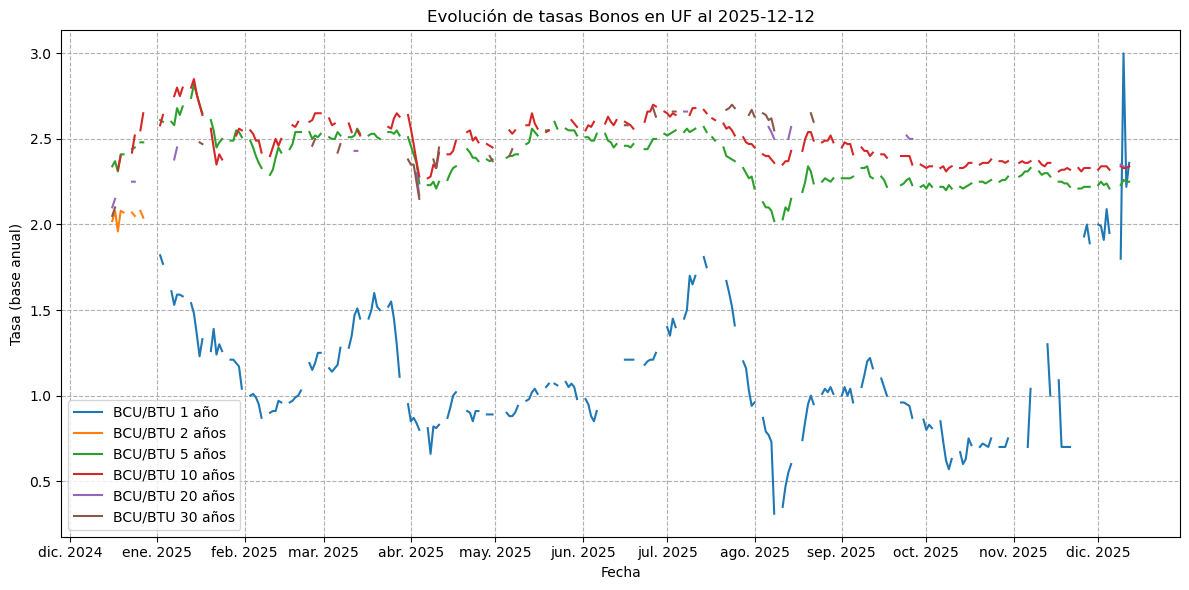

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Graficar historia de tasas Bonos UF ---
plt.figure(figsize=(12, 6))

for col in df_bonos_uf.columns:
    plt.plot(df_bonos_uf.index, df_bonos_uf[col], label=col)

# --- Fecha actual ---
fecha_actual_uf = df_bonos_uf.index[-1]

plt.title(f"Evolución de tasas Bonos en UF al {fecha_actual_uf.date()}")
plt.xlabel("Fecha")
plt.ylabel("Tasa (base anual)")
plt.legend()
plt.grid(linestyle="--")

# Formato de fechas: mostrar meses en español
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.tight_layout()
plt.show()


In [ ]:
# --- Seleccionar última fecha disponible ---
fecha_objetivo = df_bonos_uf.index[-1]

# --- Mapear columnas a plazos ---
cols_bonos_uf = [
    ("BCU/BTU 1 año", 1),
    ("BCU/BTU 2 años", 2),
    ("BCU/BTU 5 años", 5),
    ("BCU/BTU 10 años", 10),
    ("BCU/BTU 20 años", 20),
    ("BCU/BTU 30 años", 30),
]

# --- Construir arrays de plazos y tasas ---
mats_bcu, rates_bcu = [], []
for col, y in cols_bonos_uf:
    if col in df_bonos_uf.columns and pd.notna(df_bonos_uf.loc[fecha_objetivo, col]):
        mats_bcu.append(y)
        rates_bcu.append(df_bonos_uf.loc[fecha_objetivo, col])

mats_bcu = np.array(mats_bcu, dtype=float)
rates_bcu = np.array(rates_bcu, dtype=float)

# --- Estimar Svensson ---
params_svensson_bcu = estimate_svensson_params(mats_bcu, rates_bcu)

# --- Rango limitado a duración de papeles ---
min_plazo = mats_bcu.min()
max_plazo = mats_bcu.max()
rango_anos = np.linspace(min_plazo, max_plazo, 200)

# --- Calcular curva ---
yields_svensson_bcu = svensson_yield(rango_anos, *params_svensson_bcu)

# --- Graficar ---
plt.figure(figsize=(8, 5))
plt.plot(rango_anos, yields_svensson_bcu, color="red", label="Curva Svensson BCU/BTU (UF)")
plt.scatter(mats_bcu, rates_bcu, color="black", zorder=5, label="Datos observados")
plt.xlabel("Plazo (años)")
plt.ylabel("Tasa real anual (%)")
plt.title(f"Curva Svensson Bonos UF al {fecha_objetivo.date()}")
plt.grid(linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'estimate_svensson_params' is not defined